In [ ]:
!pip install pandas
!pip install nibabel
!pip install matplotlib    
!pip install transformations
!pip install scikit-learn

In [2]:
import pandas as pd
import os
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from tensorflow.keras.models import load_model
import random
import glob
import nibabel as nib
from collections import defaultdict
from tensorflow.keras.optimizers import Adam, SGD,Adagrad
from tensorflow.compat.v1 import reset_default_graph
from sklearn.model_selection import KFold
from DataLoader import dataGenerator,getIcelandicData,getIXIData,getUKBData
from Util import plotData,getPredictions,loadMR,loadHeader,calculateMeanImg
from ResNet import generateAgePredictionResNet
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.python.keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.models import load_model

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
!nvidia-smi

Fri Jun 19 17:11:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   30C    P5    29W / 250W |      0MiB / 11178MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Load Data

In [4]:
imageType = 'RawT1'
iceData = getIcelandicData(imageType)

pns = iceData['PN'].unique()
pnTrainingSet, pnTest = train_test_split(pns, test_size = 0.2,random_state=45346)
pnTrain, pnVal = train_test_split(pnTrainingSet, test_size = 0.2,random_state=257572)

train = iceData[iceData['PN'].isin(pnTrain)]
test = iceData[iceData['PN'].isin(pnTest)]
val = iceData[iceData['PN'].isin(pnVal)]

train_IXI,val_IXI = getIXIData(imageType)

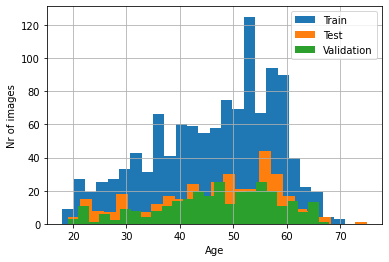

In [5]:
train.Age.hist(bins=25,label='Train')
test.Age.hist(bins=25,label='Test')
val.Age.hist(bins=25,label='Validation')
plt.xlabel('Age')
plt.ylabel('Nr of images')
plt.legend()
plt.show()

In [6]:
dataShape = (121, 145, 121)

In [7]:
#meanTrainingAge = train['Age'].mean()

In [8]:
icelandicMeanImg = calculateMeanImg(train.Loc.values)

0 done


KeyboardInterrupt: 

Age: 54.0 years


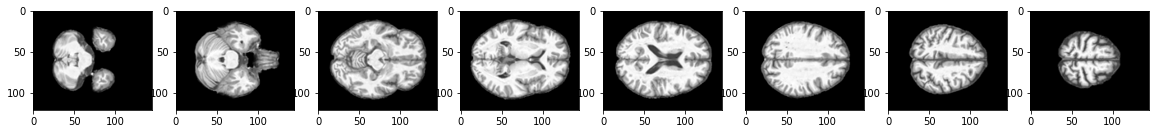

In [9]:
batchExample = dataGenerator([train.Loc.values,train.Scanner.values,train.Gender.values],train.Age.values, batch_size = 4, meanImg=None,dim=dataShape,shuffle=False,augment=False,maxAngle=40,maxShift=10)
tmp = batchExample.__getitem__(70)
print('Age: {} years'.format(tmp[1][0][0]))
plotData(tmp[0][0][:,:,:,:,:],c=2,d=10,nSlices=8)

#### Training

In [10]:
nEpochs=500
batchSize = 4
steps_per_epoch= train.shape[0]//batchSize
validation_steps = val.shape[0]//batchSize

In [11]:
default_parameters = [0.001,1e-6,'RawImg','IncludeGender','IncludeScanner',0.00005,0.2,40,10]
lr, decayRate, meanImg, gender, scanner,regAmount, dropRate, maxAngle,maxShift = default_parameters
if gender == 'RandomInput':
    gender_train = np.random.rand(train.Gender.shape[0])
    gender_val = np.random.rand(val.Gender.shape[0])
else:
    gender_train = train.Gender.values
    gender_val = val.Gender.values
if scanner == 'RandomInput':
    scanner_train = np.random.rand(train.Scanner.shape[0])
    scanner_val = np.random.rand(val.Scanner.shape[0])
else:
    scanner_train = train.Scanner.values
    scanner_val = val.Scanner.values
if meanImg == 'SubtractMean':
    meanImg = icelandicMeanImg
else:
    meanImg = None

In [11]:
model = generateAgePredictionResNet(dataShape,regAmount=regAmount,dropRate=dropRate)
#lr=0.001
#decayRate=1e-6
#momentum=0.9
adam = Adam(lr=lr, decay=decayRate)
model.compile(loss='mean_absolute_error',optimizer=adam, metrics=['mae','mse'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
mc = ModelCheckpoint('../Models/BrainAgeResNet({}-Ice)'.format(imageType),verbose=1,mode='min',save_best_only=True)
early = EarlyStopping(patience=100, verbose=1)

In [14]:
h = model.fit(dataGenerator([train.Loc.values,scanner_train,gender_train],train.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=True,augment=True,maxAngle=maxAngle,maxShift=maxShift),
                        validation_data=dataGenerator([val.Loc.values,scanner_val,gender_val],val.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch, 
                        epochs=nEpochs,
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        callbacks=[mc,early]
                           )

Epoch 1/500
 74/290 [======>.......................] - ETA: 31s - loss: 9.3496 - mean_absolute_error: 9.2845 - mean_squared_error: 132.3219
Epoch 00001: val_loss improved from inf to 9.34960, saving model to ../Models/BrainAgeResNet(GM)(Ice)
290/290 [==============================] - 146s 503ms/step - loss: 15.2541 - mean_absolute_error: 15.1890 - mean_squared_error: 741.5132 - val_loss: 9.3496 - val_mean_absolute_error: 9.2845 - val_mean_squared_error: 132.3219
Epoch 2/500
 74/290 [======>.......................] - ETA: 27s - loss: 9.2334 - mean_absolute_error: 9.1685 - mean_squared_error: 128.7752
Epoch 00002: val_loss improved from 9.34960 to 9.23341, saving model to ../Models/BrainAgeResNet(GM)(Ice)
290/290 [==============================] - 127s 437ms/step - loss: 13.0721 - mean_absolute_error: 13.0071 - mean_squared_error: 256.2055 - val_loss: 9.2334 - val_mean_absolute_error: 9.1685 - val_mean_squared_error: 128.7752
Epoch 3/500
 74/290 [======>.......................] - ETA: 28

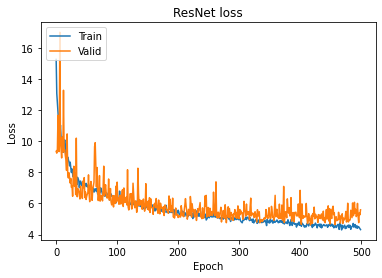

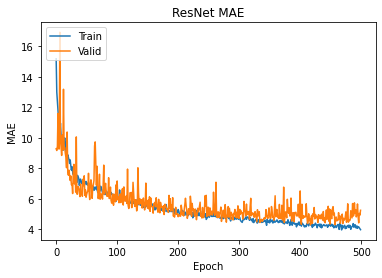

In [19]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])
plt.title('ResNet MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

In [25]:
model.save('../Models/BrainAgeResNet({}-Ice-TrainedFor{}Epochs)'.format(imageType,len(h.history['loss'])))

Let's load the weights with the lowest validation loss and fine tune them by lowering the learning rate to 0.00001, deactivateing the data augmentation, and freezeing the first residual block.

In [46]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

In [79]:
val_prediction = model.predict(dataGenerator([val.Loc.values,scanner_val,gender_val],val.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

test_prediction = model.predict(dataGenerator([test.Loc.values,test.Scanner.values,test.Gender.values],test.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False
                        )

358/358 [==============================] - 18s 51ms/step


Validation R^2:  0.7660806670087641
Test MAE:  4.292871778075759


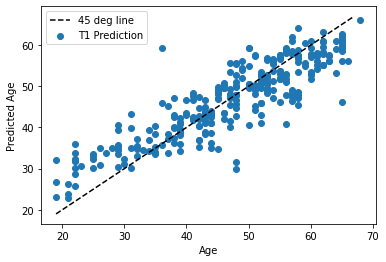

Test R^2:  0.7699790448872134
Test MAE:  4.523217963106806


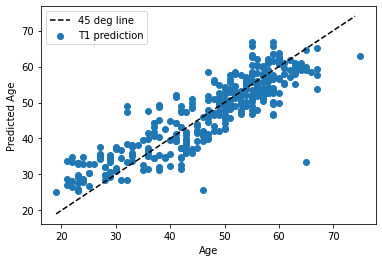

In [82]:
predictions = val_prediction[:,0]
yVal = val.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

predictions = test_prediction[:,0]
yTest = test.Age.values

print('Test R^2: ',r2_score(yTest,predictions))
print('Test MAE: ',mean_absolute_error(yTest,predictions))
y_range = np.arange(np.min(yTest),np.max(yTest))
plt.scatter(yTest,predictions,label='T1 prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

#### Transfer learning on IXI

In [57]:
ixiMeanImg = calculateMeanImg(train_IXI.Loc.values)

0 done
250 done


Age: 29.82 years


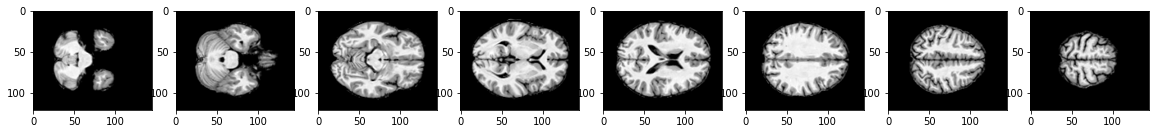

In [12]:
batchExample = dataGenerator([train_IXI.Loc.values,train_IXI.Scanner.values,train_IXI.Gender.values],train_IXI.Age.values, batch_size = 4, meanImg=None,dim=dataShape,shuffle=False,augment=False,maxAngle=40,maxShift=10)
tmp = batchExample.__getitem__(70)
print('Age: {} years'.format(tmp[1][0][0]))
plotData(tmp[0][0][:,:,:,:,:],c=2,d=10,nSlices=8)

In [13]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))
for layer in model.layers[:19]:
    layer.trainable = False

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_absolute_error',optimizer=adam,metrics=['mae','mse'])
    
batchSize = 4

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
nEpochs=250
steps_per_epoch= train_IXI.shape[0]//batchSize
validation_steps = val_IXI.shape[0]//batchSize
mc = ModelCheckpoint('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType),verbose=1,mode='min',save_best_only=True)
early = EarlyStopping(patience=100, verbose=1)

In [15]:
h = model.fit(dataGenerator([train_IXI.Loc.values,train_IXI.Scanner.values,train_IXI.Gender.values],train_IXI.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=True,augment=True,maxAngle=maxAngle,maxShift=maxShift),
                        validation_data=dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = batchSize, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch, 
                        epochs=nEpochs,
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        callbacks=[mc,early]
                           )

Epoch 1/250
 26/103 [======>.......................] - ETA: 23s - loss: 5.7534 - mean_absolute_error: 5.4278 - mean_squared_error: 46.9208
Epoch 00001: val_loss improved from inf to 5.75336, saving model to ../Models/BrainAgeResNet(RawT1-Ice-TransferLearningOnIXI)
103/103 [==============================] - 81s 785ms/step - loss: 7.2375 - mean_absolute_error: 6.9106 - mean_squared_error: 77.7031 - val_loss: 5.7534 - val_mean_absolute_error: 5.4278 - val_mean_squared_error: 46.9208
Epoch 2/250
 26/103 [======>.......................] - ETA: 13s - loss: 5.4924 - mean_absolute_error: 5.1669 - mean_squared_error: 42.1153
Epoch 00002: val_loss improved from 5.75336 to 5.49236, saving model to ../Models/BrainAgeResNet(RawT1-Ice-TransferLearningOnIXI)
103/103 [==============================] - 54s 526ms/step - loss: 6.4821 - mean_absolute_error: 6.1564 - mean_squared_error: 59.3375 - val_loss: 5.4924 - val_mean_absolute_error: 5.1669 - val_mean_squared_error: 42.1153
Epoch 3/250
 26/103 [=====

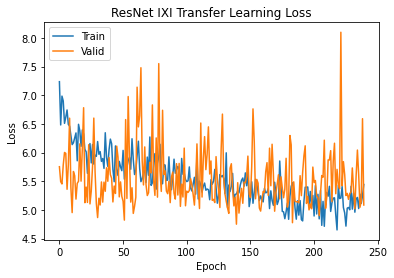

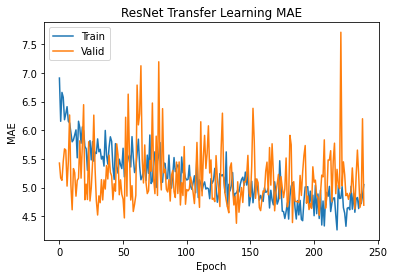

In [16]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('ResNet IXI Transfer Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])
plt.title('ResNet Transfer Learning MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

plt.show()

104/104 [==============================] - 4s 35ms/step
Validation R^2:  0.6954125818828414
Validation MAE:  7.624578798000628


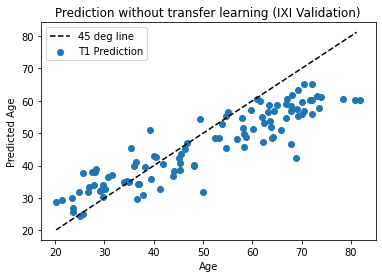

104/104 [==============================] - 3s 34ms/step
Validation R^2:  0.8917219561719723
Validation MAE:  4.377743304325984


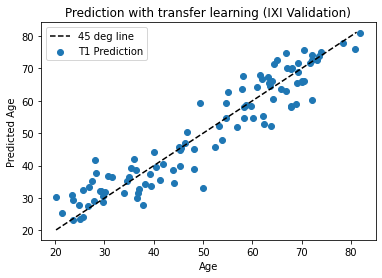

In [17]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

ixi_val_prediction_noTL = model.predict(dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ixi_val_prediction_noTL[:,0]
yVal = val_IXI.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction without transfer learning (IXI Validation)')
plt.legend()
plt.show()

model = load_model('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType))

ixi_val_prediction_TL = model.predict(dataGenerator([val_IXI.Loc.values,val_IXI.Scanner.values,val_IXI.Gender.values],val_IXI.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ixi_val_prediction_TL[:,0]
yVal = val_IXI.Age.values
print('Validation R^2: ',r2_score(yVal,predictions))
print('Validation MAE: ',mean_absolute_error(yVal,predictions))
y_range = np.arange(np.min(yVal),np.max(yVal))
plt.scatter(yVal,predictions,label='T1 Prediction')
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction with transfer learning (IXI Validation)')
plt.legend()
plt.show()

#### UK Biobank brian age prediction

In [18]:
ukb = getUKBData(imageType)

Age: 70.051 years


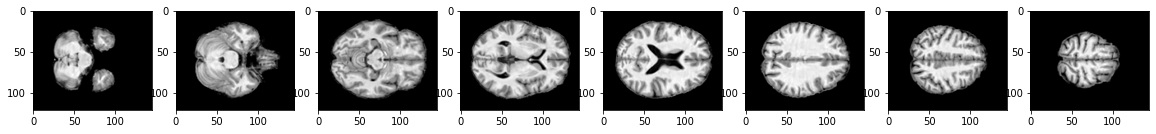

In [19]:
batchExample = dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 4, meanImg=None,dim=dataShape,shuffle=False,augment=False,maxAngle=40,maxShift=10)
tmp = batchExample.__getitem__(70)
print('Age: {} years'.format(tmp[1][0][0]))
plotData(tmp[0][0][:,:,:,:,:],c=2,d=10,nSlices=8)

Let's predict the age of the UK Biobank data using the ResNet trained on the Icelandic data only.

In [20]:
model = load_model('../Models/BrainAgeResNet({}-Ice)'.format(imageType))

In [21]:
ukb_prediction_noTL = model.predict(dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

19642/19642 [==============================] - 996s 51ms/step


R^2:  -0.4901647897355952
MAE:  7.856363274398228


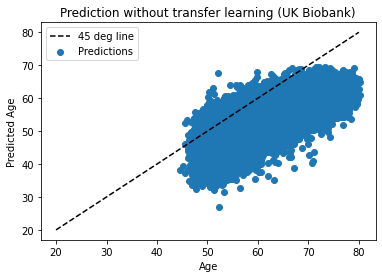

In [22]:
predictions = ukb_prediction_noTL[:,0]
y = ukb.Age.values 
print('R^2: ',r2_score(y,predictions))
print('MAE: ',mean_absolute_error(y,predictions))
plt.scatter(y,predictions,label='Predictions')
y_range = np.arange(20,np.max(y))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction without transfer learning (UK Biobank)')
plt.legend()
plt.show()

In [23]:
brainAge = pd.DataFrame({'PredictedBrainAge':np.array(predictions)},index = ukb['ID'])
brainAge.to_csv('../Results/{}_CNN_NoTL_pred.txt'.format(imageType),sep='\t')

Now let's try the model trained on the Icelandic data and IXI.

In [24]:
model = load_model('../Models/BrainAgeResNet({}-Ice-TransferLearningOnIXI)'.format(imageType))

19642/19642 [==============================] - 803s 41ms/step
R^2:  0.43643271322918475
MAE:  4.442248170924714


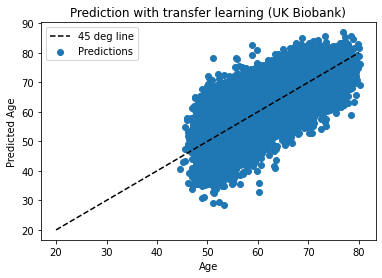

In [25]:
ukb_prediction_TL = model.predict(dataGenerator([ukb.Loc.values,ukb.Scanner.values,ukb.Gender.values],ukb.Age.values, batch_size = 1, meanImg=meanImg,dim=dataShape,shuffle=False,augment=False),
                        verbose=1,
                        max_queue_size=32,
                        workers=4,
                        use_multiprocessing=False,
                        )

predictions = ukb_prediction_TL[:,0]
y = ukb.Age.values 
print('R^2: ',r2_score(y,predictions))
print('MAE: ',mean_absolute_error(y,predictions))

plt.scatter(y,predictions,label='Predictions')
y_range = np.arange(20,np.max(y))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('Prediction with transfer learning (UK Biobank)')
plt.legend()
plt.show()

In [26]:
brainAge = pd.DataFrame({'PredictedBrainAge':np.array(predictions)},index = ukb['ID'])
brainAge.to_csv('../Results/{}_CNN_WithTL_pred.txt'.format(imageType),sep='\t')